In [41]:
import pandas as pd

# customize pandas display options
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# import plotting library
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# allow inline plotting on notebook cells
%matplotlib inline

# gives us access to numpy functions
import numpy as np

#from scipy.stats import chisquare

# allows us to implement a train test split strategy
from sklearn.model_selection import train_test_split

# access to the logistic regression class of Sklearn
from sklearn.linear_model import LogisticRegression

# model metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,roc_auc_score

# recursive feature elimination, helps in prioritizing features
from sklearn.feature_selection import RFE

# model persistence
from joblib import dump, load

In [42]:
df = pd.read_csv("risk_factors_cervical_cancer-1.csv")
df_t = df.copy(deep=True)
df_t = df_t.map(lambda x: np.nan if x == '?' else x)
df_t.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,0,0,0,0,0,0,0,0


In [43]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 858 non-null    int64 
 1   Number of sexual partners           832 non-null    object
 2   First sexual intercourse            851 non-null    object
 3   Num of pregnancies                  802 non-null    object
 4   Smokes                              845 non-null    object
 5   Smokes (years)                      845 non-null    object
 6   Smokes (packs/year)                 845 non-null    object
 7   Hormonal Contraceptives             750 non-null    object
 8   Hormonal Contraceptives (years)     750 non-null    object
 9   IUD                                 741 non-null    object
 10  IUD (years)                         741 non-null    object
 11  STDs                                753 non-null    object

In [44]:
int_col = ["Age", "Number of sexual partners", "First sexual intercourse", "Num of pregnancies"]
iud_col = [col for col in df_t.columns if "IUD" in col]
smokes_col = [col for col in df_t.columns if "Smokes" in col]
hc_col = [col for col in df_t.columns if "Hormonal Contraceptives" in col]
stds_col = [col for col in df_t.columns if "STDs" in col]
dx_col = [col for col in df_t.columns if "Dx" in col]
other_col = [col for col in df_t.columns if col not in smokes_col + hc_col + stds_col + iud_col + dx_col + int_col]
other_col

['Hinselmann', 'Schiller', 'Citology', 'Biopsy']

In [45]:
df_t = df_t.map(lambda x: x if isinstance(x, float) else np.float64(x))

for col in iud_col + smokes_col + hc_col + stds_col + dx_col + other_col:
    df_t[col] = df_t[col].astype(np.float64)
    df_t[col] = df_t[col].apply(lambda x: 0 if x == 0 else 1)

df_t.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18.0,4.0,15.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
1,15.0,1.0,14.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
2,34.0,1.0,NaN,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
3,52.0,5.0,16.0,4.0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0
4,46.0,3.0,21.0,4.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0


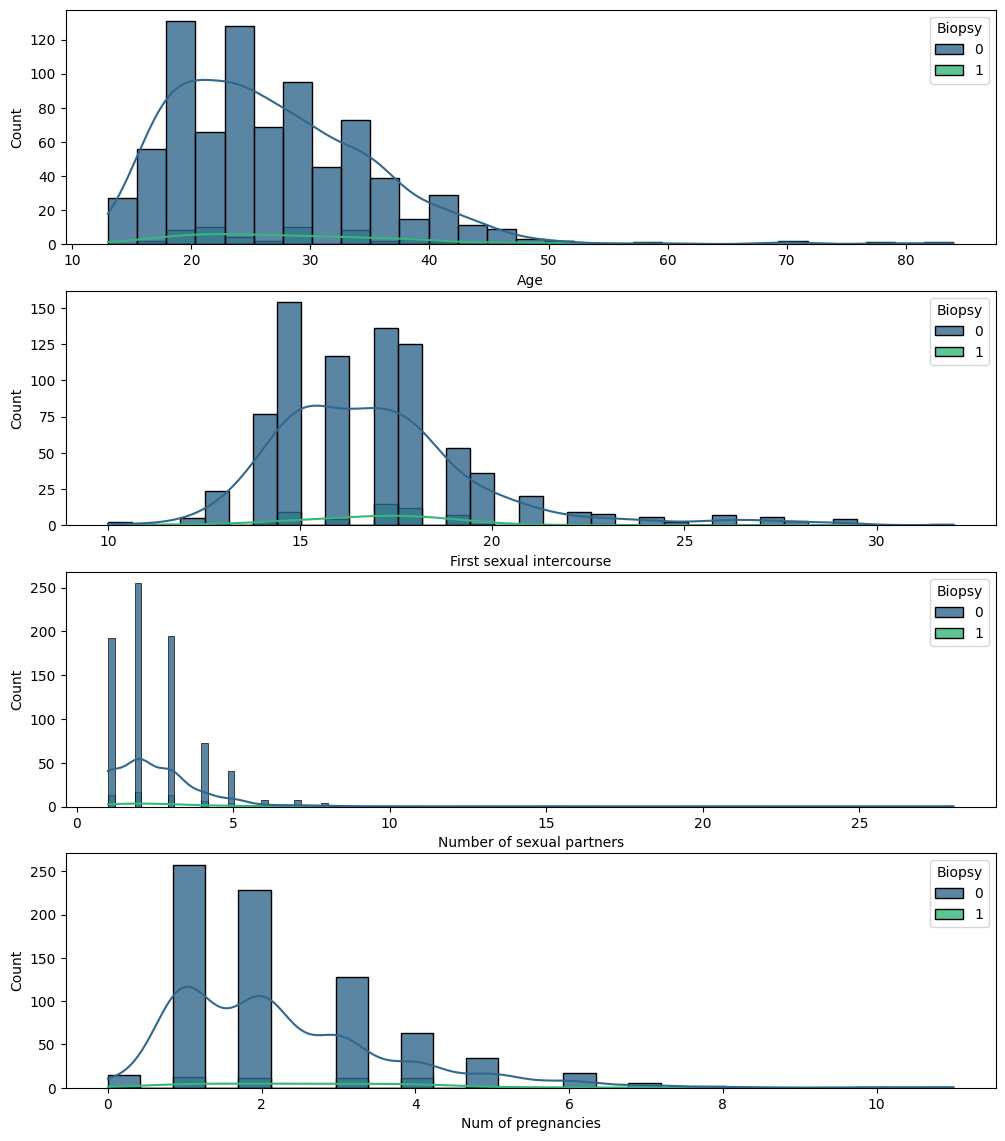

In [46]:
plot_cols = ["Age", "First sexual intercourse", "Number of sexual partners", "Num of pregnancies"]
fig, ax = plt.subplots(nrows=len(plot_cols), ncols=1, figsize=(12, 14))

for index, col in enumerate(plot_cols):
    sns.histplot(
        data=df_t,
        x=col,
        hue="Biopsy",
        palette="viridis",
        ax=ax[index],
        kde=True,
        alpha=0.8,
    )

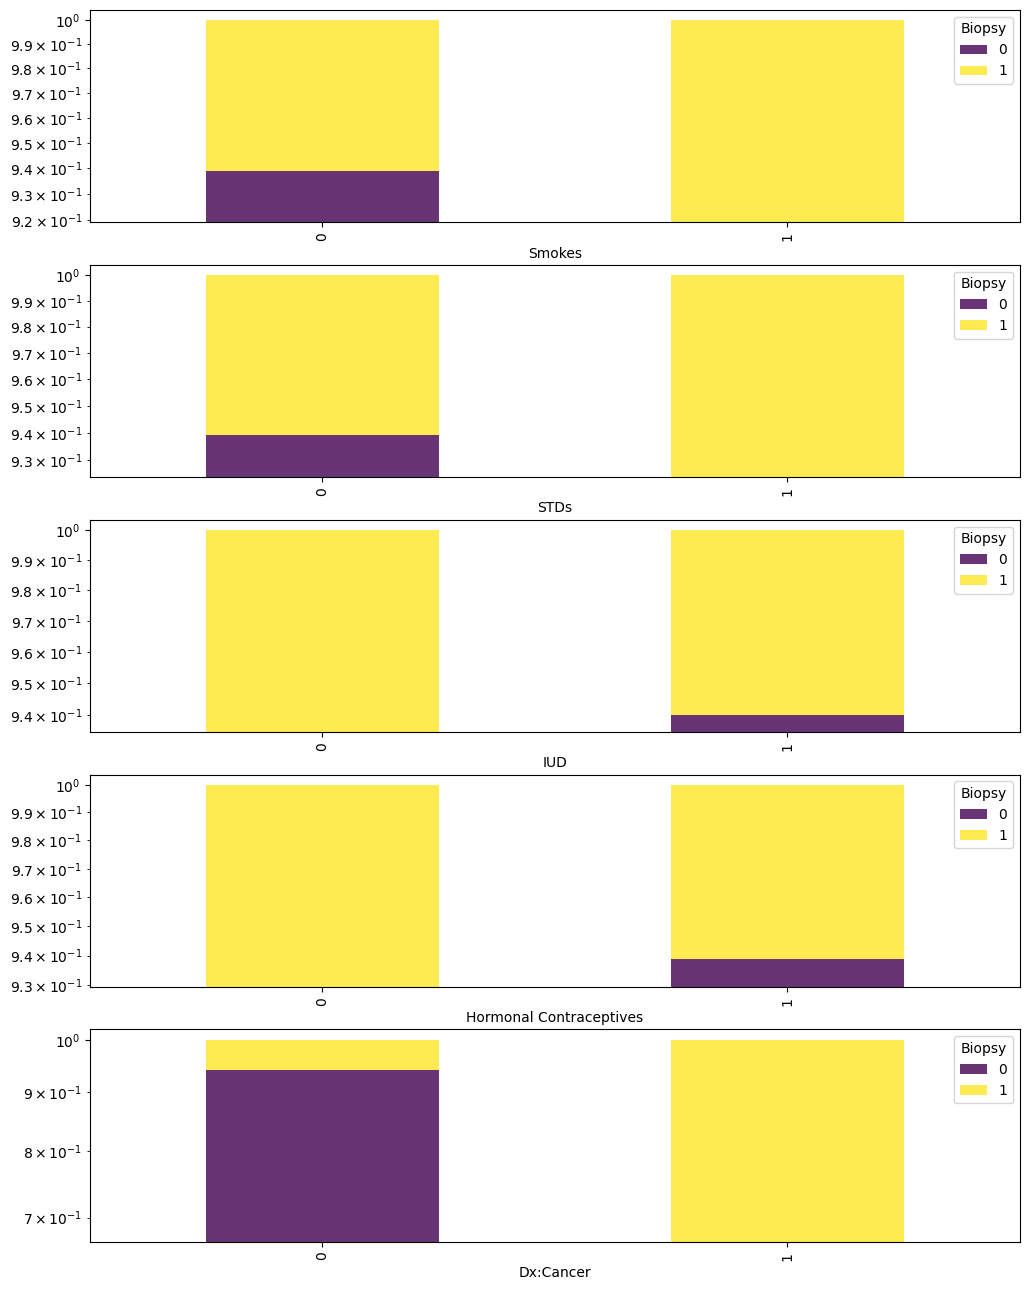

In [47]:
categorical_cols = ["Smokes", "STDs", "IUD", "Hormonal Contraceptives", "Dx:Cancer"]
fig, ax = plt.subplots(len(categorical_cols), 1, figsize=(12, 16))

for index, col in enumerate(categorical_cols):
    pd.crosstab(
        df_t[col],
        df_t["Biopsy"],
        normalize="index"
    ).plot(
        kind="bar",
        ax=ax[index],
        alpha=0.8,
        stacked=True,
        cmap="viridis"
    ).set_yscale("log")

<Axes: title={'center': 'Target'}>

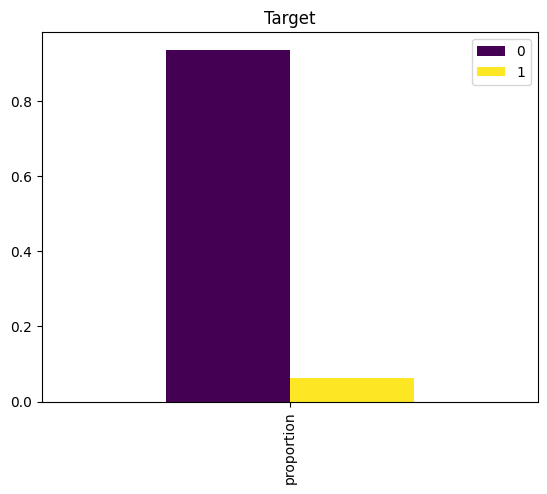

In [48]:
target_df = pd.DataFrame(df_t['Biopsy'].value_counts(normalize=True).reset_index(drop=True)).T
target_df.plot.bar(title="Target",cmap="viridis")

In [49]:
len(stds_col) / 2

8.5

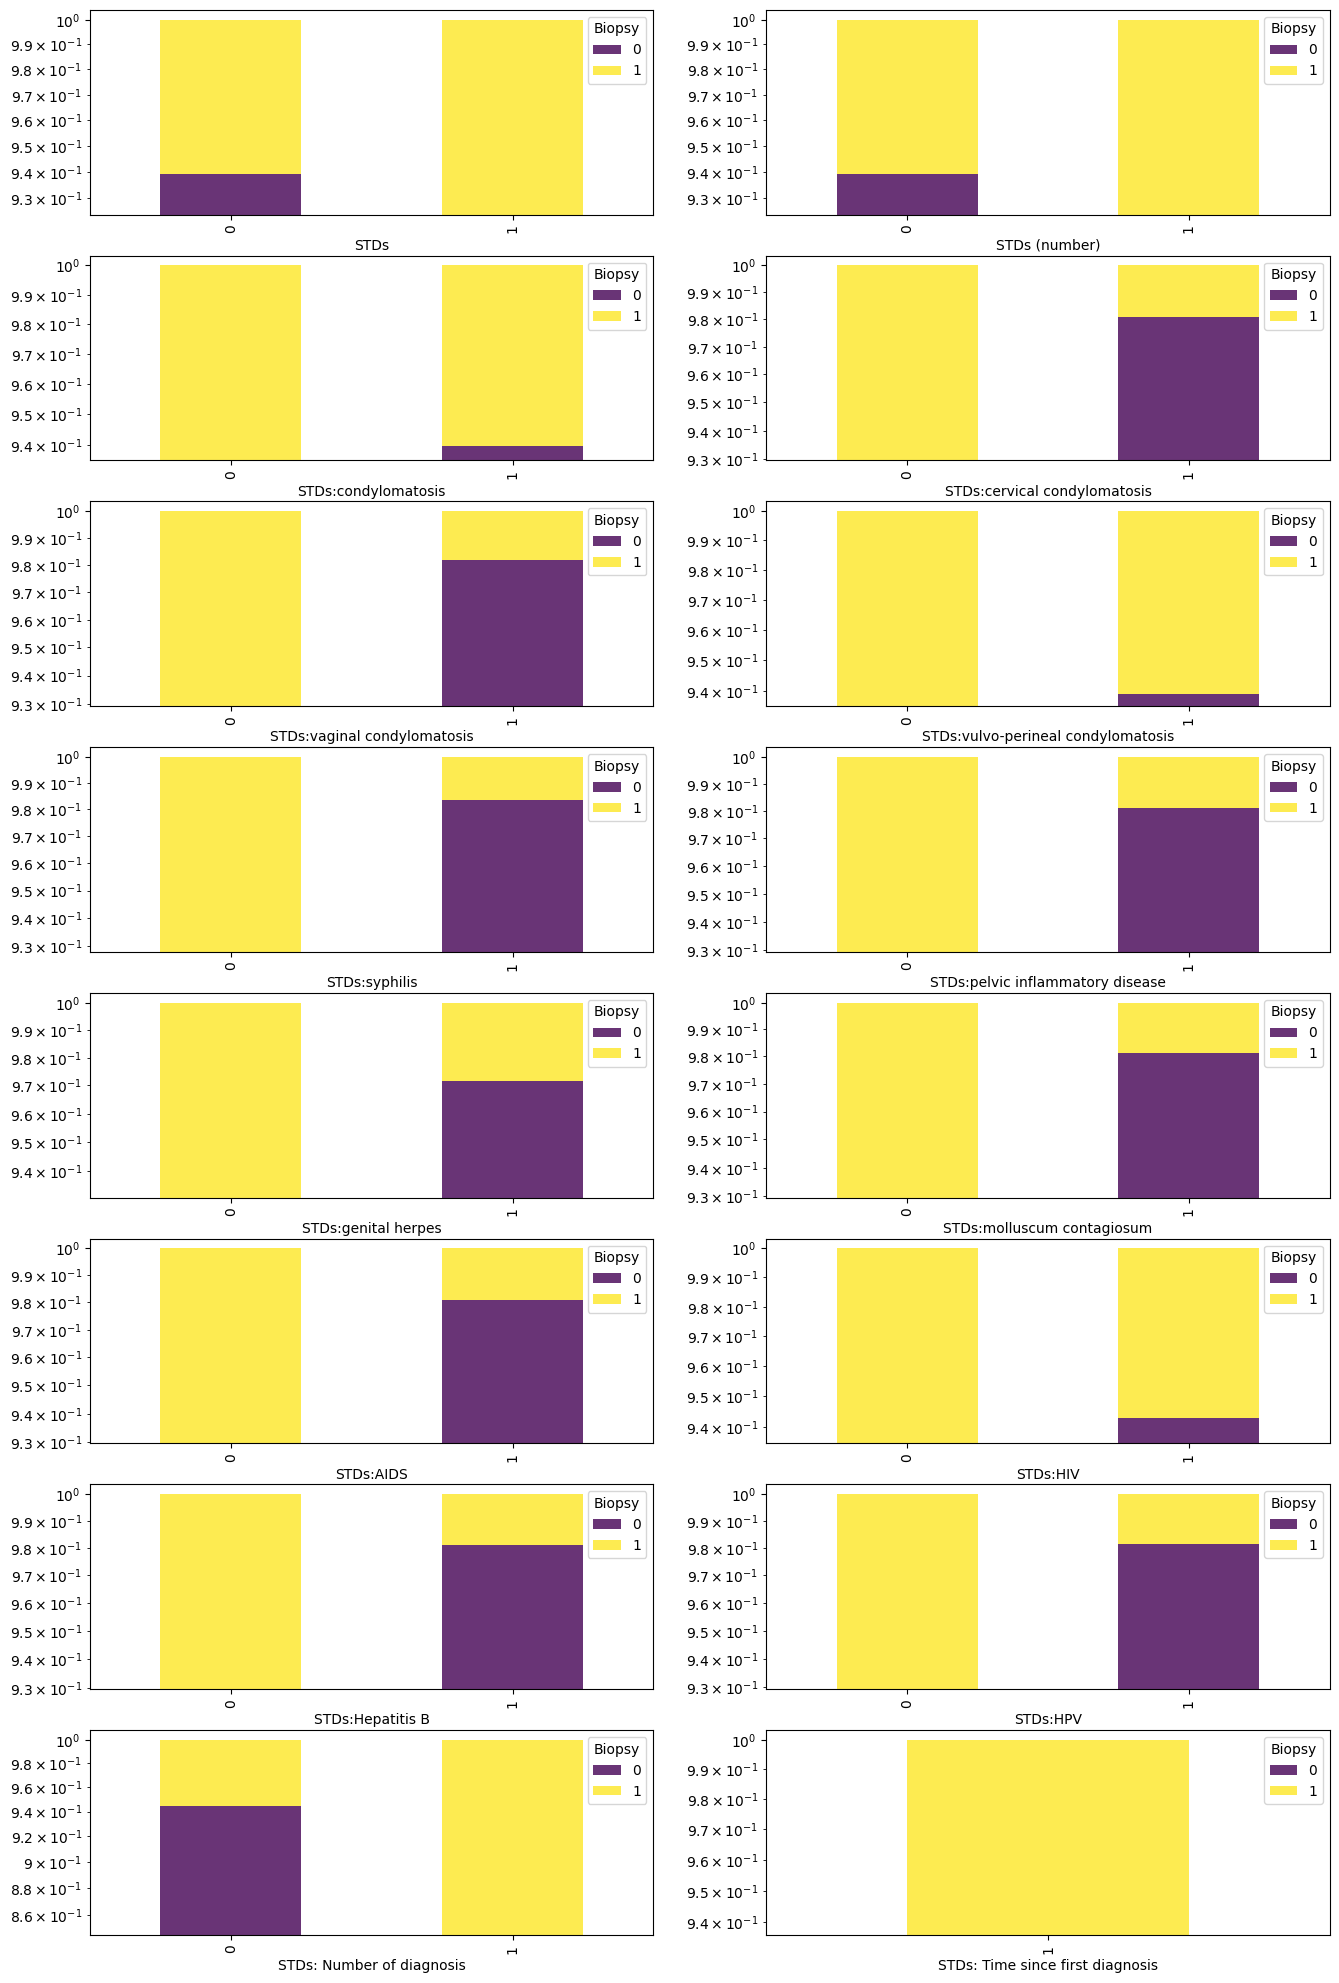

In [50]:
fig, ax = plt.subplots(len(stds_col) // 2, 2, figsize=(16, 25))

for i, col in enumerate(stds_col):
    if i % 2 == 0: j = 0
    else: j = 1

    if i // 2 < ax.shape[0]:
        pd.crosstab(
            df_t[col],
            df_t["Biopsy"],
            normalize="index"
        ).plot(
            kind="bar",
            ax=ax[i // 2, j],
            alpha=0.8,
            stacked=True,
            cmap="viridis"
        ).set_yscale("log")

In [51]:
df_t[stds_col].corr()

,STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis
STDs,1.000000,1.000000,0.877387,0.714691,0.730119,0.873821,0.782943,0.718563,0.718563,0.718563,0.714691,0.782943,0.718563,0.722425,0.574861,NaN,NaN
STDs (number),1.000000,1.000000,0.877387,0.714691,0.730119,0.873821,0.782943,0.718563,0.718563,0.718563,0.714691,0.782943,0.718563,0.722425,0.574861,NaN,NaN
STDs:condylomatosis,0.877387,0.877387,1.000000,0.814568,0.832151,0.995937,0.751884,0.809631,0.809631,0.809631,0.814568,0.769443,0.809631,0.804758,0.309006,NaN,NaN
STDs:cervical condylomatosis,0.714691,0.714691,0.814568,1.000000,0.978870,0.817891,0.912827,0.994611,0.994611,0.994611,1.000000,0.912827,0.994611,0.989294,-0.112160,NaN,NaN
STDs:vaginal condylomatosis,0.730119,0.730119,0.832151,0.978870,1.000000,0.826283,0.892583,0.973538,0.973538,0.973538,0.978870,0.892583,0.973538,0.968277,-0.063768,NaN,NaN
STDs:vulvo-perineal condylomatosis,0.873821,0.873821,0.995937,0.817891,0.826283,1.000000,0.755150,0.812948,0.812948,0.812948,0.817891,0.772756,0.812948,0.808068,0.299559,NaN,NaN
STDs:syphilis,0.782943,0.782943,0.751884,0.912827,0.892583,0.755150,1.000000,0.907666,0.907666,0.907666,0.912827,0.838659,0.907666,0.902572,0.058207,NaN,NaN
STDs:pelvic inflammatory disease,0.718563,0.718563,0.809631,0.994611,0.973538,0.812948,0.907666,1.000000,0.989236,0.989236,0.994611,0.907666,0.989236,0.983934,-0.099912,NaN,NaN
STDs:genital herpes,0.718563,0.718563,0.809631,0.994611,0.973538,0.812948,0.907666,0.989236,1.000000,0.989236,0.994611,0.907666,0.989236,0.983934,-0.099912,NaN,NaN
STDs:molluscum contagiosum,0.718563,0.718563,0.809631,0.994611,0.973538,0.812948,0.907666,0.989236,0.989236,1.000000,0.994611,0.907666,0.989236,0.983934,-0.099912,NaN,NaN


In [52]:
cols_with_missing = [col for col, ms in df_t.isna().sum().to_dict().items() if ms >= 1]
cols_with_missing

['Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies']

In [53]:
for col in cols_with_missing:
    df_t[col] = df_t[col].fillna(df_t[col].mean())
df_t.isna().sum()

Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:cervical condylomatosis          0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:AIDS                             0
STDs:HIV                              0
STDs:Hepatitis B                      0
STDs:HPV                              0


In [54]:
X_train, X_test, y_train, y_test = train_test_split(df_t.drop(columns=["Biopsy"]), df_t["Biopsy"], test_size=0.3, random_state=0)

In [55]:
# Base model using all variables
logreg = LogisticRegression(random_state=0, max_iter=10000)

# Let's input our training data set and fit our model
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=0)

In [56]:
# predict against X_test
y_pred = logreg.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0])

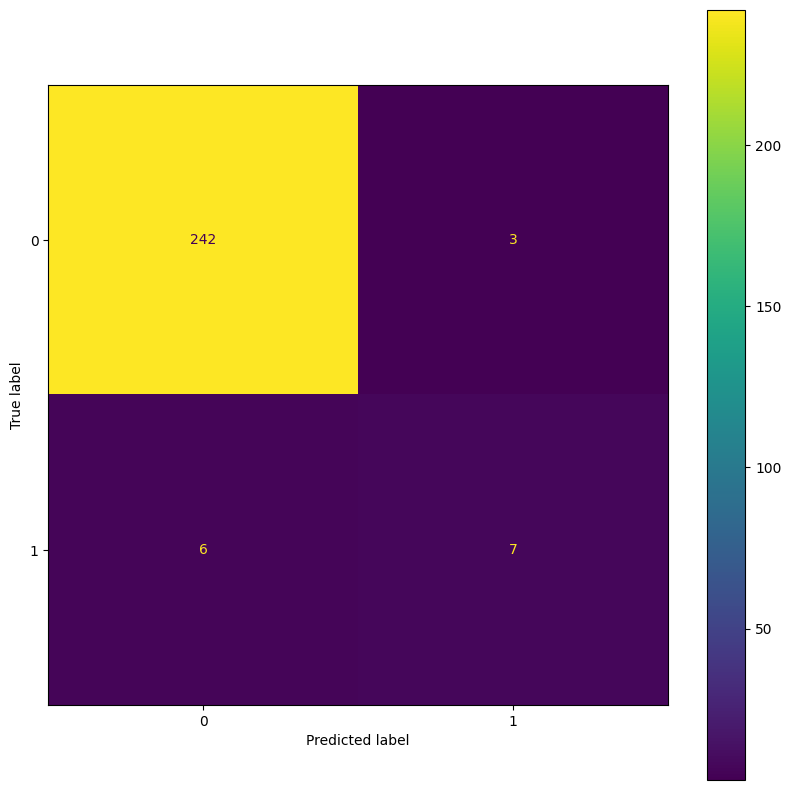

In [57]:
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test, ax=ax)
plt.show()

In [58]:
precision_score(y_test,y_pred)

0.7

In [59]:
accuracy_score( y_test,y_pred)

0.9651162790697675

In [60]:
balanced_accuracy_score(y_test, y_pred)

np.float64(0.7631083202511774)

In [61]:
recall_score(y_test, y_pred)

0.5384615384615384

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.975


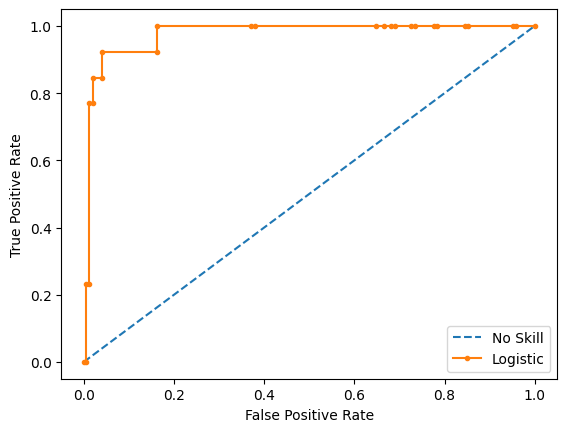

In [62]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = logreg.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [63]:
# Recursive Feature Elimination - iterate thru features and
# Using RFE to prioritize variables based on feature importance (default uses coef_ or feature_importances_)

#identify top x most significant features (default uses half)
rfe_logreg = LogisticRegression(random_state=0, max_iter=10000)
rfe = RFE(rfe_logreg) # if no value is passed for no. of features to identify, it will default to half of total features
rfe = rfe.fit(X_train, y_train)

In [64]:
# Let's make the results more human readable
rfe_df = pd.DataFrame([X_train.columns, rfe.support_,rfe.ranking_]).T
rfe_df.columns = ['name','support','rank']
rfe_df

# rank 1 or true means that the RFE method recommends these features to be used as it helps to increase accuracy metric
# given the restriction on no. of features (half of total features by default)

,name,support,rank
0,Age,False,9
1,Number of sexual partners,False,5
2,First sexual intercourse,False,18
3,Num of pregnancies,True,1
4,Smokes,False,19
5,Smokes (years),False,16
6,Smokes (packs/year),False,10
7,Hormonal Contraceptives,False,7
8,Hormonal Contraceptives (years),False,2
9,IUD,False,4


In [65]:
# List of recommended variables
rfe_df[rfe_df['support']==True]

,name,support,rank
3,Num of pregnancies,True,1
10,IUD (years),True,1
11,STDs,True,1
12,STDs (number),True,1
13,STDs:condylomatosis,True,1
15,STDs:vaginal condylomatosis,True,1
16,STDs:vulvo-perineal condylomatosis,True,1
17,STDs:syphilis,True,1
19,STDs:genital herpes,True,1
25,STDs: Number of diagnosis,True,1


In [66]:
rfe_df[rfe_df['support']==True].shape

(17, 3)

In [67]:
# Let's filter our train data set to the prioritized features
prioritized_features = rfe_df[rfe_df['support']==True]['name'].values
prioritized_X_train = X_train[prioritized_features]

In [68]:
# Use the new training data set to train/fit our new model
logreg2 = LogisticRegression(random_state=0,solver='liblinear',max_iter=100)
logreg2.fit(prioritized_X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [69]:
# predict against X test
prioritized_y_pred = logreg2.predict(X_test[prioritized_features])
prioritized_y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0])

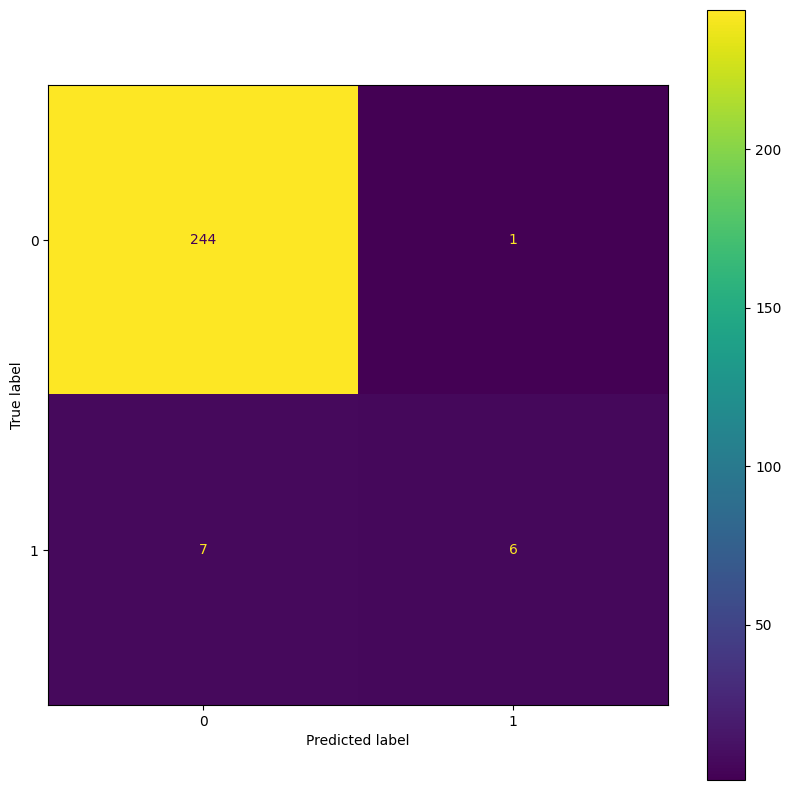

In [70]:
# confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_estimator(logreg2, X_test[prioritized_features], y_test, ax=ax)
plt.show()

No Skill: ROC AUC=0.50000
Logistic: ROC AUC=0.98791


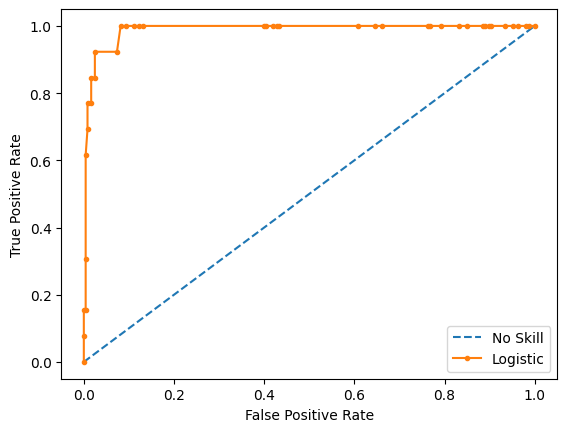

In [71]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = logreg2.predict_proba(X_test[prioritized_features])
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
prioritized_lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.5f' % (ns_auc))
print('Logistic: ROC AUC=%.5f' % (prioritized_lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()